# Predicting Patient Length of Stay Using MIMIC-III Data
Giovanna Graciani
## Problem Statement
Predict patient length of stay in ICU; Discharge within 5 days = {Yes, No}.


In [61]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import model_selection
import seaborn as sns
import matplotlib.pyplot as plt
import dateutil

MIMIC_DIR = "../mimic3/"

## Overview of files & features contained in mimic3 dataset

In [62]:
for fname in os.listdir(MIMIC_DIR):
    if not fname.endswith("csv"):
        continue
        
    print("-------- -------- Printing info about " + fname + " -------- --------")   
    filedir = MIMIC_DIR + fname
    print("File Size in MB: " + str(os.path.getsize(filedir) / 1000000))

    data = pd.read_csv(filedir, nrows=100)
    print(data.info())
    

-------- -------- Printing info about PROCEDUREEVENTS_MV.csv -------- --------
File Size in MB: 48
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 25 columns):
ROW_ID                        100 non-null int64
SUBJECT_ID                    100 non-null int64
HADM_ID                       100 non-null int64
ICUSTAY_ID                    100 non-null int64
STARTTIME                     100 non-null object
ENDTIME                       100 non-null object
ITEMID                        100 non-null int64
VALUE                         100 non-null int64
VALUEUOM                      100 non-null object
LOCATION                      15 non-null object
LOCATIONCATEGORY              15 non-null object
STORETIME                     100 non-null object
CGID                          100 non-null int64
ORDERID                       100 non-null int64
LINKORDERID                   100 non-null int64
ORDERCATEGORYNAME             100 non-null object
SECONDAR

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 19 columns):
ROW_ID               100 non-null int64
SUBJECT_ID           100 non-null int64
HADM_ID              100 non-null int64
ICUSTAY_ID           28 non-null float64
STARTDATE            100 non-null object
ENDDATE              100 non-null object
DRUG_TYPE            100 non-null object
DRUG                 100 non-null object
DRUG_NAME_POE        54 non-null object
DRUG_NAME_GENERIC    54 non-null object
FORMULARY_DRUG_CD    100 non-null object
GSN                  84 non-null float64
NDC                  100 non-null int64
PROD_STRENGTH        100 non-null object
DOSE_VAL_RX          100 non-null object
DOSE_UNIT_RX         100 non-null object
FORM_VAL_DISP        100 non-null object
FORM_UNIT_DISP       100 non-null object
ROUTE                100 non-null object
dtypes: float64(2), int64(4), object(13)
memory usage: 14.9+ KB
None
-------- -------- Printing info about PROCEDURES_ICD.c

## Analyze ICU stays data

In [63]:
icu_stays = pd.read_csv(MIMIC_DIR + "ICUSTAYS.csv")

round(icu_stays["LOS"].mean(), 0)

5.0

In [64]:
icu_stays.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [65]:
icu_stays = icu_stays.drop(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'INTIME', 'OUTTIME', 'ICUSTAY_ID'], axis=1)
icu_stays = icu_stays.dropna()
le = LabelEncoder()
icu_stays['DBSOURCE'] = le.fit_transform(icu_stays['DBSOURCE'])
icu_stays['FIRST_CAREUNIT'] = le.fit_transform(icu_stays['FIRST_CAREUNIT'])
icu_stays['LAST_CAREUNIT'] = le.fit_transform(icu_stays['LAST_CAREUNIT'])
icu_stays.head()
icu_stays['LOS'] = icu_stays['LOS'].apply(lambda x: 0 if x <= 5 else 1)

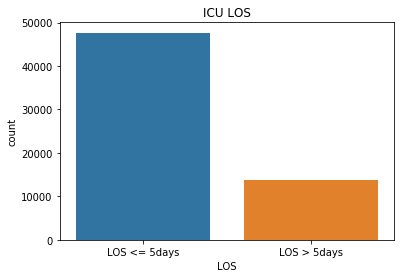

In [66]:
ns = sns.countplot(x=icu_stays['LOS'], data=icu_stays)
ns.set_title("ICU LOS")
x_ticks_labels=['LOS <= 5days', 'LOS > 5days']
ns.set_xticklabels(x_ticks_labels)
plt.show()

In [67]:
y = icu_stays['LOS']
X = icu_stays.drop(['LOS'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [68]:
from sklearn.feature_selection import RFE
names = X.columns.values
logreg = LogisticRegression()
rfe=RFE(logreg)
rfe=rfe.fit(X, y)
print("Features sorted by rank:")
print(sorted(zip(map(lambda x: round(x,4), rfe.ranking_),names)))

Features sorted by rank:
[(1.0, 'DBSOURCE'), (1.0, 'LAST_CAREUNIT'), (2.0, 'FIRST_CAREUNIT'), (3.0, 'FIRST_WARDID'), (4.0, 'LAST_WARDID')]


In [69]:
icu_stays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61522 entries, 0 to 61531
Data columns (total 6 columns):
DBSOURCE          61522 non-null int64
FIRST_CAREUNIT    61522 non-null int64
LAST_CAREUNIT     61522 non-null int64
FIRST_WARDID      61522 non-null int64
LAST_WARDID       61522 non-null int64
LOS               61522 non-null int64
dtypes: int64(6)
memory usage: 5.8 MB


### Baseline results

In [70]:
logreg = LogisticRegression()
logreg = logreg.fit(X_train, y_train)

In [71]:
y_predict = logreg.predict_proba(X_test)
my_list = map(lambda x: x[1], y_predict)
y_pred = pd.Series(my_list).round()

In [72]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))

confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n",confusion_matrix)

Accuracy: 0.77
('Confusion matrix:\n', array([[14277,     0],
       [ 4180,     0]]))


In [73]:
tn, fp, fn, tp = confusion_matrix.ravel()
#Sensitivity: TP/(TP+FN)
sensitivity1 = tp/(tp+fn)
#sensitivity1 = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
print('Sensitivity : ', round(sensitivity1,3))

#Specificity: TN/(TN+FP)
specificity1 = tn/(tn+fp)
print('Specificity : ', round(specificity1,3))

('Sensitivity : ', 0.0)
('Specificity : ', 1.0)


### Baseline results using 10-fold cross validation

In [74]:
models = []
results = []
names = []
scoring = 'accuracy'
seed = 7
models.append(('LR', LogisticRegression()))

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%0.3f (+/- %0.3f)" % (name, cv_results.mean(), cv_results.std() * 2)
    print(msg)

LR:	0.775 (+/- 0.064)


## Analyze Admissions data

In [75]:
import dateutil
# Compute length of stay from the admissions data set
admissions_data = pd.read_csv(MIMIC_DIR+"ADMISSIONS.csv")
admissions_data["DISCHTIME"] = pd.to_datetime(admissions_data["DISCHTIME"])
admissions_data["ADMITTIME"] = pd.to_datetime(admissions_data["ADMITTIME"])
admissions_data["LOS"] = admissions_data["DISCHTIME"] - admissions_data["ADMITTIME"]

In [76]:
from sklearn.tree import DecisionTreeClassifier as Model
from sklearn.feature_selection import RFE
# Try logreg and rfe on just this data w/o anything else fancy

icd9_diagnoses = pd.read_csv(MIMIC_DIR + "DIAGNOSES_ICD.csv")
# Admissions and Diagnoses table
admit_diag = pd.merge(admissions_data, icd9_diagnoses, on="HADM_ID", suffixes=("_admit", "_diag"))
admit_diag.set_index('HADM_ID')
groupie = admit_diag.groupby('HADM_ID').size()
groupie = groupie.to_frame()

admissions_data = admissions_data.join(groupie, lsuffix='_admit', rsuffix='_cm', on='HADM_ID')
admissions_data

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS,0
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,1 days 03:28:00,7
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,5 days 11:55:00,8
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,6 days 18:26:00,10
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,2 days 20:34:00,4
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,3 days 12:49:00,4
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,V-TACH,0,1,6 days 23:44:00,9
6,27,27,134931,2191-11-30 22:16:00,2191-12-03 14:45:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1,2 days 16:29:00,4
7,28,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,5 days 08:45:00,11
8,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1,5 days 00:20:00,9
9,30,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,STATUS EPILEPTICUS,1,1,7 days 15:33:00,8


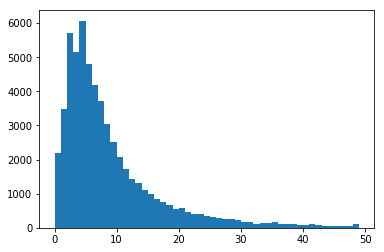

In [77]:
plt.hist(admissions_data["LOS"].dt.days, bins=range(0,50))
plt.show()

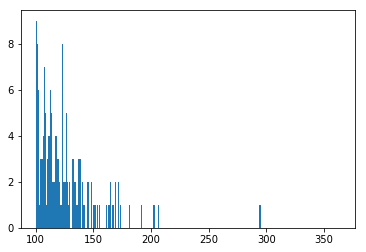

In [78]:
plt.hist(admissions_data["LOS"].dt.days, bins=range(100, 365))
plt.show()

In [79]:
admissions_data['LOSDays'] = admissions_data['LOS'].dt.days

df = admissions_data[admissions_data['LOSDays'] > 2]
df = df[df["LOSDays"] < 5]
count1 = df["LOSDays"].count() 
count2 = admissions_data['LOSDays'].count()
print("Percentage of admissions within 2 -> 5 days " + str((count1 * 1.0 / count2) * 100))


Percentage of admissions within 2 -> 5 days 19.0026451437873


In [80]:
admissions_data['LOSDays'].mean()

9.610672137818774

## Join Patients.csv, Admission.csv, DIAGNOSIS_ICD.csv & ICU.csv
Clean data & prepare for model training, remove all data that would not be available at time of admission

In [150]:
icd9_diagnoses = pd.read_csv(MIMIC_DIR + "DIAGNOSES_ICD.csv")
# Admissions and Diagnoses table
admit_diag = pd.merge(admissions_data, icd9_diagnoses, on="HADM_ID", suffixes=("_admit", "_diag"))
admit_diag.set_index('HADM_ID')
groupie = admit_diag.groupby('HADM_ID').size()
groupie = pd.DataFrame(groupie).reset_index()
groupie.columns=['HADM_ID','Comorbidity_sum']


admissions_data = pd.merge(admissions_data, groupie, on='HADM_ID')
#admissions_data['0'].rename('Comorbidity_Sum')

In [151]:
admissions_data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS,LOSDays,Comorbidity_sum
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,1 days 03:28:00,1,7
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,5 days 11:55:00,5,8
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,6 days 18:26:00,6,10
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,2 days 20:34:00,2,4
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,3 days 12:49:00,3,4


In [152]:
# Join admissions, patient and icustays data
# compute age at admissions from admit data - dob
pd.set_option('display.max_columns', None)
patients  = pd.read_csv(MIMIC_DIR + "PATIENTS.csv")
icu_stays = pd.read_csv(MIMIC_DIR + "ICUSTAYS.csv")
l = "_left"
r = "_right"

admit_patient_icu_stays = pd.merge(admissions_data, patients, on="SUBJECT_ID", suffixes=("_admit", "_patient"))
admit_patient_icu_stays = pd.merge(admit_patient_icu_stays, icu_stays, on="HADM_ID", suffixes=("_admit", "_icu"))

# Compute age on date of admission
admit_patient_icu_stays["DOB"] = pd.to_datetime(admit_patient_icu_stays["DOB"]) 
admit_patient_icu_stays["AGE"] = abs(admit_patient_icu_stays["ADMITTIME"] - admit_patient_icu_stays["DOB"])
admit_patient_icu_stays["AGE"] = pd.to_numeric(admit_patient_icu_stays["AGE"].dt.days // 365)
admit_patient_icu_stays.head(25)

,ROW_ID_admit,SUBJECT_ID_admit,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS_admit,0,LOSDays,Comorbidity_sum,ROW_ID_patient,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ROW_ID,SUBJECT_ID_icu,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS_icu,AGE
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,1 days 03:28:00,7,1,7,19,F,2131-05-07,NaN,NaN,NaN,0,22,22,204798,carevue,MICU,MICU,52,52,2196-04-09 12:27:00,2196-04-10 15:54:00,1.1438,64
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,5 days 11:55:00,8,5,8,20,M,2082-07-17,NaN,NaN,NaN,0,23,23,227807,carevue,CSRU,CSRU,14,14,2153-09-03 09:38:55,2153-09-04 15:59:11,1.2641,71
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,6 days 18:26:00,10,6,10,20,M,2082-07-17,NaN,NaN,NaN,0,24,23,234044,metavision,SICU,SICU,57,57,2157-10-21 11:40:38,2157-10-22 16:08:48,1.1862,75
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,2 days 20:34:00,4,2,4,21,M,2100-05-31,NaN,NaN,NaN,0,25,24,262236,carevue,CCU,CCU,7,7,2139-06-06 16:15:36,2139-06-07 04:33:25,0.5124,39
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,3 days 12:49:00,4,3,4,22,M,2101-11-21,NaN,NaN,NaN,0,26,25,203487,carevue,CCU,CCU,7,7,2160-11-02 03:16:23,2160-11-05 16:23:27,3.5466,58
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,V-TACH,0,1,6 days 23:44:00,9,6,9,23,M,2054-05-04,2128-02-25 00:00:00,NaN,2128-02-25 00:00:00,1,27,26,244882,carevue,CCU,CCU,57,57,2126-05-07 09:52:30,2126-05-09 13:15:05,2.1407,72
6,27,27,134931,2191-11-30 22:16:00,2191-12-03 14:45:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1,2 days 16:29:00,4,2,4,24,F,2191-11-30,NaN,NaN,NaN,0,28,27,298615,carevue,NICU,NICU,56,56,2191-11-30 22:21:15,2191-12-01 01:28:12,0.1298,0
7,28,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,5 days 08:45:00,11,5,11,25,M,2103-04-15,NaN,NaN,NaN,0,29,28,225559,carevue,CSRU,CSRU,14,14,2177-09-01 09:32:26,2177-09-02 12:28:42,1.1224,74
8,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1,5 days 00:20:00,9,5,9,26,M,1872-10-14 00:00:00,NaN,NaN,NaN,0,30,30,225176,carevue,CCU,CCU,57,57,2172-10-14 17:24:00,2172-10-16 13:44:00,1.8472,284
9,30,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,STATUS EPILEPTICUS,1,1,7 days 15:33:00,8,7,8,27,M,2036-05-17,2108-08-30 00:00:00,2108-08-30 00:00:00,2108-08-30 00:00:00,1,31,31,254478,carevue,MICU,MICU,15,15,2108-08-22 23:28:42,2108-08-30 21:59:20,7.9379,72


In [82]:
data = admit_patient_icu_stays.drop(['AGE','LAST_WARDID','LAST_CAREUNIT','ADMITTIME','SUBJECT_ID_icu','ICUSTAY_ID','EXPIRE_FLAG','DISCHARGE_LOCATION','HAS_CHARTEVENTS_DATA','LOS_admit','HADM_ID','ROW_ID_admit','SUBJECT_ID_admit','DISCHTIME','DEATHTIME','EDREGTIME','EDOUTTIME','HOSPITAL_EXPIRE_FLAG','DIAGNOSIS','ROW_ID_patient','DOB','DOD','DOD_HOSP','DOD_SSN', 'ROW_ID','INTIME','OUTTIME'], axis=1)
data = data[data.FIRST_CAREUNIT != 'NICU']
data = data.dropna()

In [83]:
#Encode features
le = LabelEncoder()
data['ADMISSION_TYPE'] = le.fit_transform(data['ADMISSION_TYPE'])
data['ADMISSION_LOCATION'] = le.fit_transform(data['ADMISSION_LOCATION'])
data['INSURANCE'] = le.fit_transform(data['INSURANCE'])
data['LANGUAGE'] = le.fit_transform(data['LANGUAGE'])
data['RELIGION'] = le.fit_transform(data['RELIGION'])
data['MARITAL_STATUS'] = le.fit_transform(data['ADMISSION_TYPE'])
data['ETHNICITY'] = le.fit_transform(data['ETHNICITY'])
data['GENDER'] = le.fit_transform(data['GENDER'])
data['DBSOURCE'] = le.fit_transform(data['DBSOURCE'])
data['FIRST_CAREUNIT'] = le.fit_transform(data['FIRST_CAREUNIT'])
#data['LAST_CAREUNIT'] = le.fit_transform(data['LAST_CAREUNIT'])

In [84]:
data['LOS_ICU_bin'] = data['LOS_icu'].apply(lambda x: 0 if x <= 5 else 1)

In [156]:
#data['LOS_admit_vs_icu'] = round(abs((data['LOSDays'] - data['LOS_icu'])),0)
data['LOS_admit_vs_icu'] = round((data['LOSDays'] / data['LOS_icu']),3)
data = data.drop(['LOS_icu'],axis=1)
data = data.dropna()

## Feature Exploration

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33941 entries, 2 to 61531
Data columns (total 15 columns):
ADMISSION_TYPE        33941 non-null int64
ADMISSION_LOCATION    33941 non-null int64
INSURANCE             33941 non-null int64
LANGUAGE              33941 non-null int64
RELIGION              33941 non-null int64
MARITAL_STATUS        33941 non-null int64
ETHNICITY             33941 non-null int64
0                     33941 non-null int64
LOSDays               33941 non-null int64
Comorbidity_sum       33941 non-null int64
GENDER                33941 non-null int64
DBSOURCE              33941 non-null int64
FIRST_CAREUNIT        33941 non-null int64
FIRST_WARDID          33941 non-null int64
LOS_icu               33941 non-null float64
LOS_ICU_bin           33941 non-null int64
dtypes: float64(1), int64(14)
memory usage: 4.1 MB


In [87]:
admissions_data_all = pd.read_csv(MIMIC_DIR+"ADMISSIONS.csv")

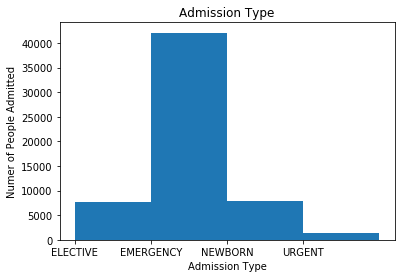

In [88]:
plt.hist(admissions_data["ADMISSION_TYPE"], bins=range(0,5))
plt.title("Admission Type")
plt.ylabel("Numer of People Admitted")
plt.xlabel("Admission Type")
plt.show()

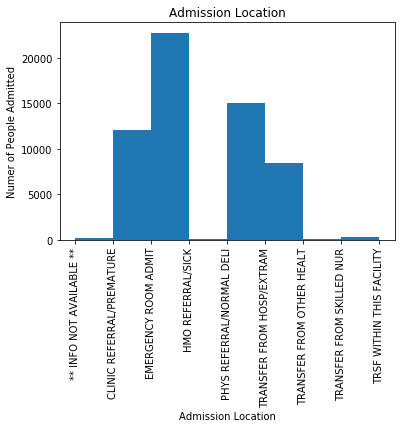

In [89]:
plt.hist(admissions_data["ADMISSION_LOCATION"], bins=range(0,9))
plt.xticks(rotation='vertical')
plt.title("Admission Location")
plt.ylabel("Numer of People Admitted")
plt.xlabel("Admission Location")
plt.show()

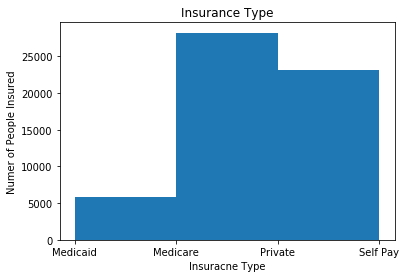

In [95]:
plt.hist(admissions_data_all["INSURANCE"], bins=range(1,5))
plt.title("Insurance Type")
plt.ylabel("Numer of People Insured")
plt.xlabel("Insuracne Type")
plt.show()

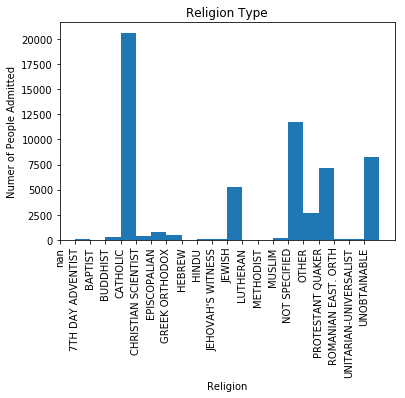

In [108]:
plt.hist(admissions_data_all["RELIGION"], bins=range(0,21))
plt.xticks(rotation='vertical')
plt.title("Religion Type")
plt.ylabel("Numer of People Admitted")
plt.xlabel("Religion")
plt.show()

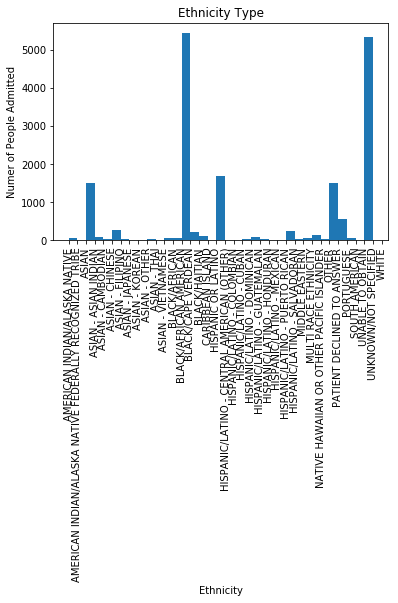

In [109]:
plt.hist(admissions_data_all["ETHNICITY"], bins=range(0,36))
plt.xticks(rotation='vertical')
plt.title("Ethnicity Type")
plt.ylabel("Numer of People Admitted")
plt.xlabel("Ethnicity")
plt.show()

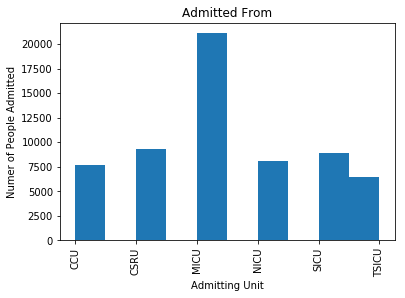

In [129]:
icu_stays = pd.read_csv(MIMIC_DIR+"ICUSTAYS.csv")

plt.hist(icu_stays["FIRST_CAREUNIT"])
plt.xticks(rotation='vertical')
plt.title("Admitted From")
plt.ylabel("Numer of People Admitted")
plt.xlabel("Admitting Unit")
plt.show()

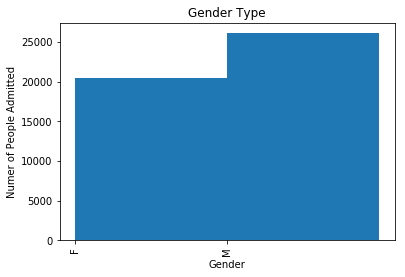

In [130]:
patient = pd.read_csv(MIMIC_DIR+"PATIENTS.csv")
plt.hist(patient["GENDER"], bins=range(0,3))
plt.xticks(rotation='vertical')
plt.title("Gender Type")
plt.ylabel("Numer of People Admitted")
plt.xlabel("Gender")
plt.show()

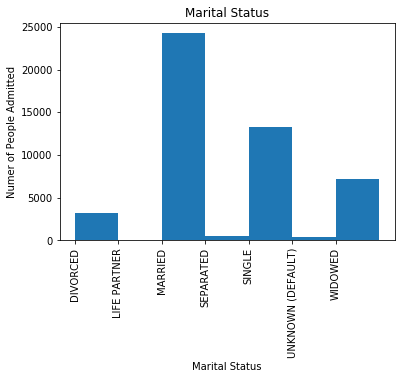

In [133]:
plt.hist(admissions_data_all["MARITAL_STATUS"], bins=range(0,8))
plt.xticks(rotation='vertical')
plt.title("Marital Status")
plt.ylabel("Numer of People Admitted")
plt.xlabel("Marital Status")
plt.show()

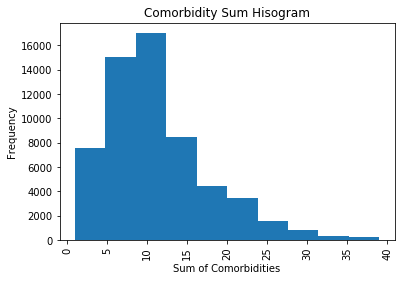

In [194]:
plt.hist(admissions_data["Comorbidity_sum"])
plt.title("Comorbidity Sum Hisogram")
plt.xticks(rotation='vertical')
plt.xlabel("Sum of Comorbidities")
plt.ylabel("Frequency")
plt.show()

# Create Logisitc Regression Model

In [190]:
y = data['LOS_ICU_bin']
X = data.drop(['LOS_ICU_bin'],axis=1)#,'LOS_admit_vs_icu', 'DBSOURCE','GENDER','INSURANCE','RELIGION','LANGUAGE','FIRST_WARDID','ETHNICITY'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [191]:
from sklearn.feature_selection import RFE
names = X.columns.values
logreg = LogisticRegression()
rfe=RFE(logreg)
rfe=rfe.fit(X, y)
print("Features sorted by rank:")
print(sorted(zip(map(lambda x: round(x,4), rfe.ranking_),names)))

Features sorted by rank:
[(1, 'ADMISSION_LOCATION'), (1, 'ADMISSION_TYPE'), (1, 'Comorbidity_sum'), (1, 'DBSOURCE'), (1, 'LOSDays'), (1, 'LOS_admit_vs_icu'), (1, 'MARITAL_STATUS'), (2, 'FIRST_CAREUNIT'), (3, 'GENDER'), (4, 'RELIGION'), (5, 'INSURANCE'), (6, 'ETHNICITY'), (7, 'LANGUAGE'), (8, 'FIRST_WARDID')]


In [192]:
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    msg = "%s:\t%0.3f (+/- %0.3f)" % (name, cv_results.mean(), cv_results.std() * 2)
    print(msg)
    print('Min accuracy:', round(cv_results.min(),3))
    print('Max accuracy:', round(cv_results.max(),3))

LR:	0.989 (+/- 0.003)
Min accuracy: 0.987
Max accuracy: 0.991


In [175]:
logreg = LogisticRegression()
logreg = logreg.fit(X_train, y_train)
y_predict = logreg.predict_proba(X_test)
my_list = map(lambda x: x[1], y_predict)
y_pred = pd.Series(my_list).round()

/Users/giovannagraciani/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [178]:
import numpy as np
print('Accuracy : {:.3f}'.format(accuracy_score(y_test, y_pred)))

confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix :\n",confusion_matrix)

Accuracy : 0.988
Confusion matrix :
 [[8238   22]
 [ 100 1823]]


In [179]:
tn, fp, fn, tp = confusion_matrix.ravel()

In [180]:
#Sensitivity: TP/(TP+FN)
sensitivity1 = tp/(tp+fn)
#sensitivity1 = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
print('Sensitivity : ', round(sensitivity1,3))

#Specificity: TN/(TN+FP)
specificity1 = tn/(tn+fp)
print('Specificity : ', round(specificity1,3))

Sensitivity :  0.948
Specificity :  0.997
